# ABPA classification

The classification of Aspergillus sucks, so here we use the ABPA classifications!

In this data frame we are using the Bacterial+Archaeal+Viral+Eukaryote encodings, and so we call them COPFe to distinguish them from the primarily bacterial ones used elsewhere.

This notebook makes Fig. S8


Note: the first version of this uses an earlier ABPA classification. Fur

In [1]:
import os
import sys
from socket import gethostname

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib

sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', all_taxa=True, taxa="family")

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


## Read the autoencoder

In [2]:
encoder_models = 'cluster_gbrfs_eukaryotes'
if not os.path.exists(os.path.join(encoder_models, 'clusters.json')):
    print("Please run the autoencoder code before trying to load the models.", file=sys.stderr)
    exit(1)

if not os.path.exists(os.path.join(encoder_models, 'pc_df.tsv')):
    print("Please create and save the PCA before trying to load the models.", file=sys.stderr)
    exit(1)

with open(os.path.join(encoder_models, 'clusters.json'), 'r') as file:
    data = json.load(file)
tmpjsondf = pd.DataFrame(list(data.items()), columns=['COPFe', 'Feature'])
cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
cluster_assignments['COPFe'] = cluster_assignments['COPFe'].astype(int)

pc_df = pd.read_csv(os.path.join(encoder_models, 'pc_df.tsv'), sep="\t", index_col=0)

## Drop those without IgE measurements

These can't be used for ABPA diagnosis, so we drop them

In [3]:
metadata = metadata.dropna(subset=['Spec IgE'], axis=0)

# Generate the ABPA Classification

The recommendations are:
A. Aspergillus Sensitisation (AS)
 - Not ABPA.
 - Defined by:
     - A. fumigatus–specific IgE ≥ 0.35 kUA/L
     - Total IgE < 500 IU/mL
B. ABPA (yes/no)
 - ABPA requires:
 - Aspergillus sensitisation (Spec IgE ≥ 0.35) AND
 - Total IgE ≥ 500 IU/mL AND
 - ≥1 supportive criterion, such as:
     - Spec IgG ≥ 27 mgA/L
     - Positive precipitins
     - Radiology (not available)
     - Eosinophilia (not available)


In [4]:
def classify_ISHAM2024(row):
    IgE = row['IgE']
    sIgE = row['Spec IgE']
    sIgG = row['Spec IgG']
    prec = row['Precipitins']
    
    sensitised = sIgE >= 0.35
    
    if sensitised and IgE >= 500 and (sIgG >= 27 or prec >= 1):
        return 'ABPA'
    elif sensitised:
        return 'Sensitised'
    else:
        return 'Not sensitised'

metadata['ABPA_ISHAM2024'] = metadata.apply(classify_ISHAM2024, axis=1)
mapping = {'Not sensitised': 0, 'Sensitised': 1, 'ABPA': 2}

metadata['ABPA_ISHAM2024_cat'] = metadata['ABPA_ISHAM2024'].replace(mapping)
metadata['ABPA'] = (metadata['ABPA_ISHAM2024'] == 'ABPA').astype(int).astype('category')

In [5]:
metadata[['pwCF_ID', 'IgE', 'Spec IgE', 'Spec IgG', 'Precipitins', 'ABPA_ISHAM2024', 'ABPA_ISHAM2024_cat', 'ABPA']].dropna(subset=['Spec IgE'], axis=0).sort_values(by='IgE')

,pwCF_ID,IgE,Spec IgE,Spec IgG,Precipitins,ABPA_ISHAM2024,ABPA_ISHAM2024_cat,ABPA
NAME,,,,,,,,
802971_20180605_S,802971,0.0,0.00,9.0,0.0,Not sensitised,0,0
1447437_20171212_S,1447437,3.0,0.00,NaN,0.0,Not sensitised,0,0
763742_20170925_S,763742,3.0,0.00,NaN,0.0,Not sensitised,0,0
895293_20180502_S,895293,4.0,0.00,55.0,0.0,Not sensitised,0,0
763742_20180129_S,763742,5.0,0.00,NaN,0.0,Not sensitised,0,0
748699_20190101_S,748699,6.0,0.00,63.0,2.0,Not sensitised,0,0
877469_20190115_S,877469,8.0,0.00,6.0,0.0,Not sensitised,0,0
748699_20190114_S,748699,8.0,0.00,69.0,2.0,Not sensitised,0,0
748699_20180410_S,748699,9.0,0.00,58.0,0.0,Not sensitised,0,0


In [6]:
metadata.groupby('ABPA_ISHAM2024').count()

,MinION,PromethION,MGI,pwCF_ID,Sample date,IP vs OP,Hospital,Room,Age,Age groups,...,Sum of steroid + mabs,DNA_extraction_ conc,SAGC ULN,DNA Conc. (ng/ul),Index I7,Index I5,Mean_Size_BP,Total Clusters Passing Filter (Million),ABPA_ISHAM2024_cat,ABPA
ABPA_ISHAM2024,,,,,,,,,,,,,,,,,,,,,
ABPA,2,1,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
Not sensitised,10,0,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
Sensitised,14,2,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26


### Summary of the number of pwCF with ABPA

In [7]:
summary = (
    metadata.groupby('ABPA_ISHAM2024')
    .agg(
        total_samples=('ABPA_ISHAM2024', 'size'),
        unique_pwCF=('pwCF_ID', 'nunique')
    )
    .reset_index()
)

print(summary)

   ABPA_ISHAM2024  total_samples  unique_pwCF
0            ABPA              7            4
1  Not sensitised             18           15
2      Sensitised             26           18


## Run the GBRF

First on the multiclass (0-2 categories) data

_NOTE_ You can not run a ROC curve on the multi-class data because you can't get FP/TP

We used 95 estimators for the random forest regressor
Mean squared error for ABPA_ISHAM2024_cat using regressor is 0.6386767717443077


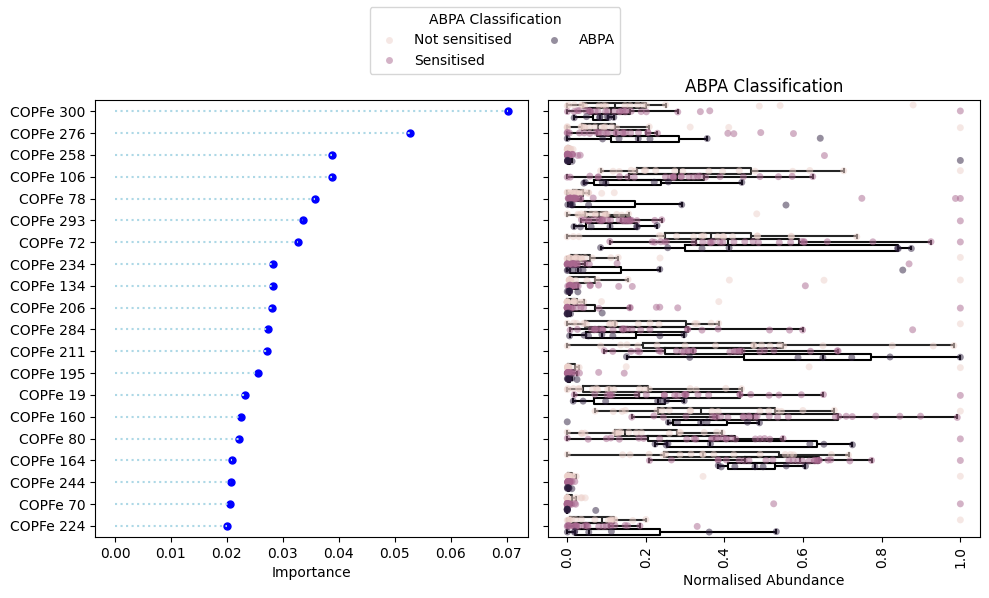

In [8]:
intcol = 'ABPA_ISHAM2024_cat'

#intcol_title = replace_index.sub('', intcol).replace('_', ' ')
intcol_title = 'ABPA Classification'
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)
custom_labels = {mapping[x]:x for x in mapping}

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y, n_estimators=1000, n_iter_no_change=20)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)

cf_analysis_lib.plot_one_top_feature(merged_df, feature_importances_sorted, intcol, intcol_title, 
                                     custom_labels, 
                                     plot_legend=True)

## Run a GBRF on the binary data

The data for the classifier is {'no': 44, 'yes': 7} variables
We used 295 estimators for the random forest classifier
Mean squared error for ABPA using classifier is 0.2727272727272727


(n = 51)


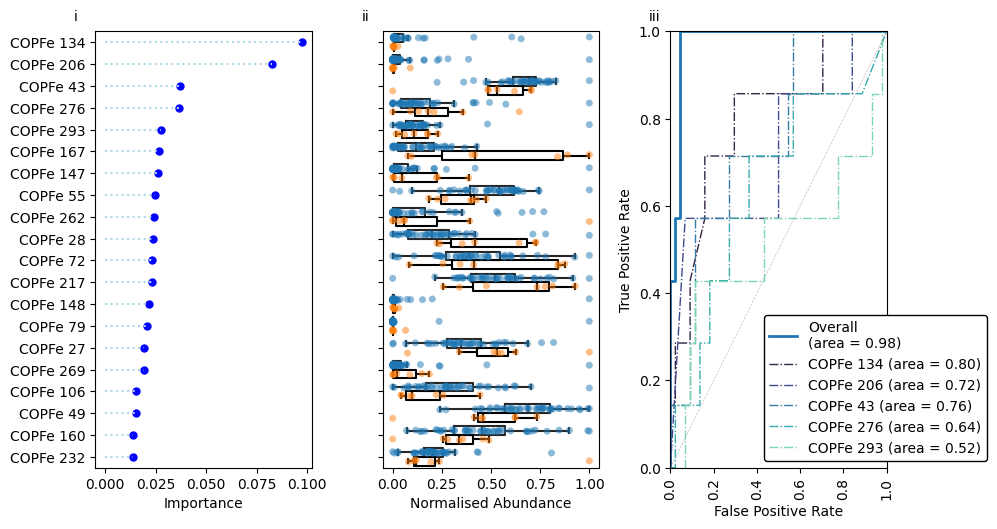

In [9]:
intcol = 'ABPA'

intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y, n_estimators=1000, n_iter_no_change=20)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)
fig, axes = cf_analysis_lib.plot_importance_abundance_roc(merged_df, feature_importances_sorted, intcol, intcol_title, model,
                                     custom_labels, plot_legend=False)

labels = [cf_analysis_lib.int2roman(i+1) for i in range(3)] # this makes the labels roman numerals
for ax, label in zip(axes, labels):
    ax.text(-0.1, 1.05, label, transform=ax.transAxes,
            fontsize=10, va='top', ha='left')
    ax.set_title("")
plt.savefig('final_images/figS8.png', dpi=300)
plt.savefig('final_images/figS8.svg')
print(f"(n = {merged_df.shape[0]})")
cf_analysis_lib.create_thumbnail("figS8.png")

In [19]:
cluster_assignments[cluster_assignments['COPFe']==134]

,COPFe,Feature
707,134,Pleurotaceae
708,134,Saprolegniaceae
709,134,Geothermincolaceae
710,134,Coenobitidae
711,134,Allomimiviridae
712,134,Lymnaeidae
713,134,Cyanophoraceae
714,134,Chlorophyll Degradation
715,134,Nyssaceae
716,134,Ornithorhynchidae


In [20]:
cluster_assignments[cluster_assignments['COPFe']==206]

,COPFe,Feature
1540,206,Trematosphaeriaceae
1541,206,Lophiotremataceae
1542,206,Methylacidiphilaceae
1543,206,Dipicolinate Synthesis
1544,206,Temoridae
1545,206,Sordariaceae
1546,206,Bionectriaceae
1547,206,Zopfiaceae
1548,206,Pseudodiploosporaceae
1549,206,Ceratocystidaceae


# Generate the ABPA Classification

Note that this uses an older ISHAM/CFF classification for ABPA, and the above classification is the newer version. The information below here is now out of date!

We create a new metadata `categorical` column for the ABPA classification.
                                             
Feature	| Threshold(s) | Rationale | Source
--- | --- | --- | ---
IgE (total)	| ≥500 | possible ABPA 	| CF Foundation & ISHAM criteria.
|| ≥1000 | probable/strong ABPA
Spec IgE | ≥0.35 | sensitised | ImmunoCAP grading (0.35–100 kUA/L).
|| ≥1.0 | strong sensitisation
|| ≥10 | very strong ABPA-associated sensitisation 
Spec IgG | >40 | exposed or colonised | Typical cut-offs in CF diagnostic panels.
|| ≥100 | chronic colonisation or ABPA
Precipitins | 0 | negative | Semiquantitative serology grading.
|| 1 | weak positive (exposure)
|| 2 | strong positive (active immune response)


Category | Criteria| Meaning
--- | --- | ---
0 – No sensitisation | IgE < 100 and Spec_IgE < 0.35 and Spec_IgG ≤ 40 and Precipitins == 0 | No evidence of fungal exposure.
1 – Sensitised | 100 ≤ IgE < 500 or Spec_IgE ≥ 0.35 | Sensitised but no allergic disease.
2 – Possible ABPA | (IgE ≥ 500 and Spec_IgE ≥ 1.0) or (Spec_IgG ≥ 100) or (Precipitins ≥ 1) | Immune response consistent with ABPA; needs confirmation.
3 – Probable ABPA | (IgE ≥ 1000 and Spec_IgE ≥ 10) or (Precipitins == 2) | Meets serologic thresholds for ABPA; likely disease.

In [10]:
def classify_abpa(row):
    IgE = row['IgE']
    Spec_IgE = row['Spec IgE']
    Spec_IgG = row['Spec IgG']
    Precipitins = row['Precipitins']

    if IgE >= 1000 and Spec_IgE >= 10 or Precipitins == 2:
        return 3  # Probable ABPA
    elif IgE >= 500 and Spec_IgE >= 1 or Spec_IgG >= 100 or Precipitins >= 1:
        return 2  # Possible ABPA
    elif IgE >= 100 or Spec_IgE >= 0.35:
        return 1  # Sensitised
    else:
        return 0  # No sensitisation

igs = ['IgE', 'Spec IgE', 'Spec IgG', 'Precipitins']
metadata = metadata.dropna(how='all', subset=igs)
metadata['ABPA_status'] = metadata.apply(classify_abpa, axis=1).astype('category')

# create a single binary value for ABPA status
metadata['ABPA_positive'] = (metadata['ABPA_status'].astype(int) >=2).astype('int').astype('category')

intcols = ['ABPA_status', 'ABPA_positive'] + igs + ['CS_Aspergillus fumigatus', 'CS_Aspergillus flavus', 'CS_Aspergillus nidulans', 'CS_Aspergillus niger', 'CS_Aspergillus terreus']
metadata[intcols].sort_values(by='ABPA_status', ascending=False)

,ABPA_status,ABPA_positive,IgE,Spec IgE,Spec IgG,Precipitins,CS_Aspergillus fumigatus,CS_Aspergillus flavus,CS_Aspergillus nidulans,CS_Aspergillus niger,CS_Aspergillus terreus
NAME,,,,,,,,,,,
634207_20180510_S,3,1,1750.0,31.00,122.0,1.0,0,1,0,0,0
698917_20180119_S,3,1,67.0,0.71,NaN,2.0,0,0,0,0,0
785991_20171129_S,3,1,88.0,2.60,NaN,2.0,0,0,0,0,0
778851_20171204_S,3,1,345.0,13.00,NaN,2.0,0,0,0,0,0
983493_20180123_S,3,1,12.0,0.92,NaN,2.0,0,0,0,0,0
752797_20170918_S,3,1,263.0,5.70,NaN,2.0,0,0,0,0,0
748699_20190101_S,3,1,6.0,0.00,63.0,2.0,1,0,0,0,0
698564_20171001_S,3,1,891.0,52.00,NaN,2.0,0,0,0,0,0
748699_20190114_S,3,1,8.0,0.00,69.0,2.0,0,0,0,0,0


In [11]:
metadata.groupby('ABPA_status').count()

,MinION,PromethION,MGI,pwCF_ID,Sample date,IP vs OP,Hospital,Room,Age,Age groups,...,SAGC ULN,DNA Conc. (ng/ul),Index I7,Index I5,Mean_Size_BP,Total Clusters Passing Filter (Million),ABPA_ISHAM2024,ABPA_ISHAM2024_cat,ABPA,ABPA_positive
ABPA_status,,,,,,,,,,,,,,,,,,,,,
0,8,0,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
1,7,1,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
2,6,1,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
3,5,1,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12


## Summary of the number of samples and number of pwCF with each classification of ABPA

In [12]:
summary = (
    metadata.groupby('ABPA_status')
    .agg(
        total_samples=('ABPA_status', 'size'),
        unique_pwCF=('pwCF_ID', 'nunique')
    )
    .reset_index()
)

print(summary)

  ABPA_status  total_samples  unique_pwCF
0           0             12           11
1           1             16           13
2           2             11            6
3           3             12           10


## Run the GBRF

First on the multiclass (0-3 categories) data

_NOTE_ You can not run a ROC curve on the multi-class data because you can't get FP/TP

The data for the classifier is {1: 16, 0: 12, 3: 12, 2: 11} variables
We used 182 estimators for the random forest classifier
Mean squared error for ABPA_status using classifier is 2.272727272727273


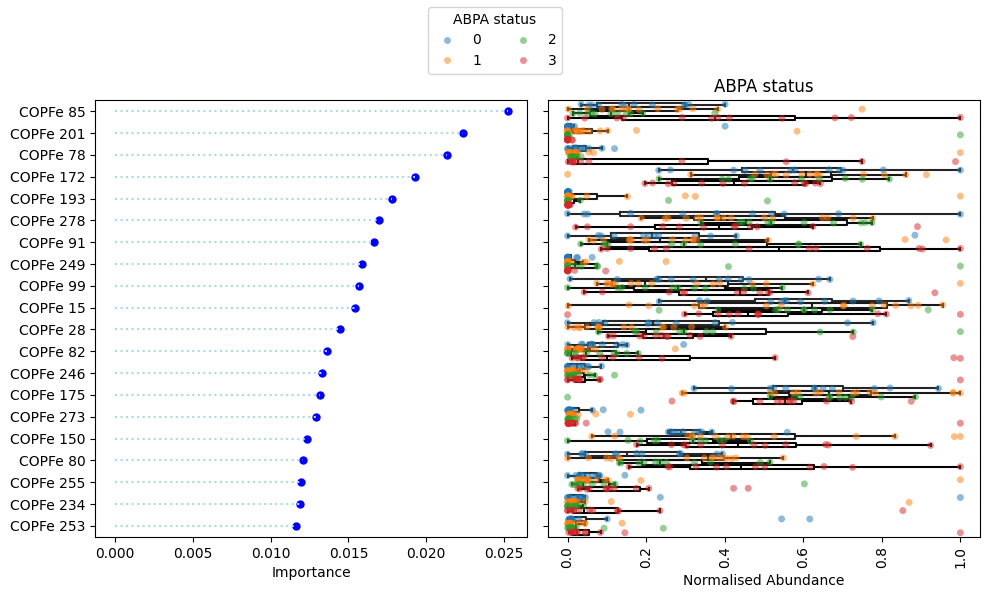

In [13]:
intcol = 'ABPA_status'

intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y, n_estimators=1000, n_iter_no_change=20)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)

cf_analysis_lib.plot_one_top_feature(merged_df, feature_importances_sorted, intcol, intcol_title, 
                                     custom_labels, 
                                     plot_legend=True)

## Run the GBRF

Next, on the binary data

The data for the classifier is {'no': 28, 'yes': 23} variables
We used 208 estimators for the random forest classifier
Mean squared error for ABPA_positive using classifier is 0.45454545454545453


(n = 51)


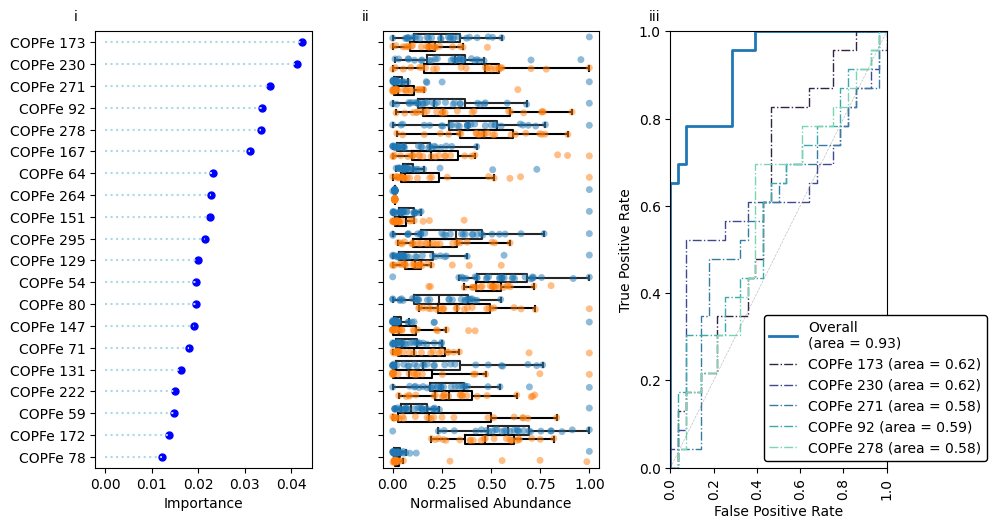

In [14]:
intcol = 'ABPA_positive'

intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y, n_estimators=1000, n_iter_no_change=20)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)
fig, axes = cf_analysis_lib.plot_importance_abundance_roc(merged_df, feature_importances_sorted, intcol, intcol_title, model,
                                     custom_labels, plot_legend=False)

labels = [cf_analysis_lib.int2roman(i+1) for i in range(3)] # this makes the labels roman numerals
for ax, label in zip(axes, labels):
    ax.text(-0.1, 1.05, label, transform=ax.transAxes,
            fontsize=10, va='top', ha='left')
    ax.set_title("")
#plt.savefig('final_images/figS8.png', dpi=300)
#plt.savefig('final_images/figS8.svg')
print(f"(n = {merged_df.shape[0]})")
#cf_analysis_lib.create_thumbnail("figS8.png")

In [15]:
cluster_assignments[cluster_assignments['Feature'].str.lower().str.contains('asper')]

,COPFe,Feature
1913,253,Aspergillaceae


In [16]:
cluster_assignments[cluster_assignments['COPFe']==47]

,COPFe,Feature
141,47,DNA Repair Base Excision
142,47,Repair of Iron Centers


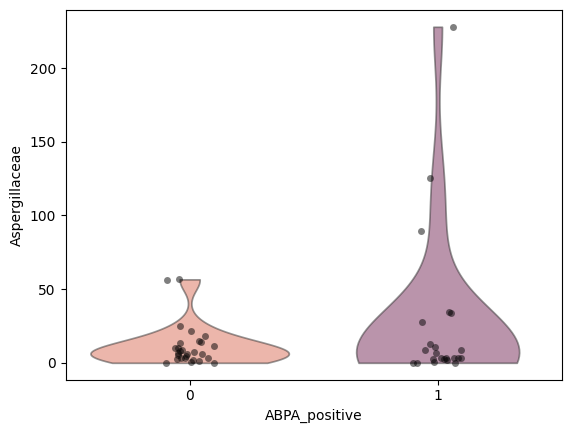

In [17]:
intcol = 'ABPA_positive'
merged = df.join(metadata[[intcol]], how='inner').dropna(subset=intcol)
g = sns.violinplot(x=intcol, y='Aspergillaceae', data=merged, hue=intcol, palette='rocket_r', alpha=0.5, legend=False, inner=None, density_norm='count', common_norm=True, cut=0)
g = sns.stripplot(x=intcol, y='Aspergillaceae', data=merged, color='black', jitter=True, alpha=0.5,  legend=False)

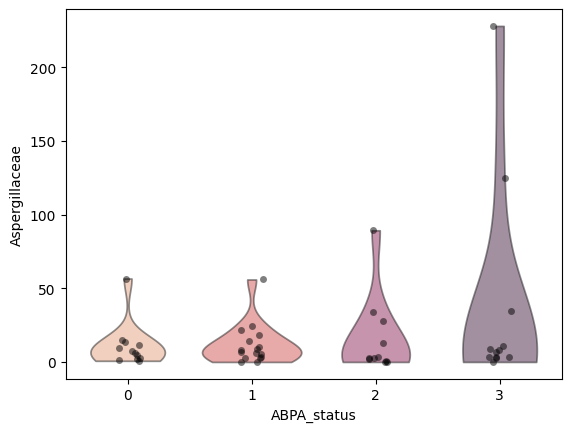

In [18]:
intcol = 'ABPA_status'
merged = df.join(metadata[[intcol]], how='inner').dropna(subset=intcol)
g = sns.violinplot(x=intcol, y='Aspergillaceae', data=merged, hue=intcol, palette='rocket_r', alpha=0.5, legend=False, inner=None, density_norm='count', common_norm=True, cut=0)
g = sns.stripplot(x=intcol, y='Aspergillaceae', data=merged, color='black', jitter=True, alpha=0.5,  legend=False)